Import necessary librairies

In [109]:
import sys
import os
import time
import numpy as np
import pandas as pd
import warnings
import healpy as hp
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path_folder = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0,path_folder+'/../debvader/')
import cutout_img_dc2

import FoFCatalogMatching
import GCRCatalogs
import lsst.geom
import lsst.daf.persistence as dafPersist

### Generate a field image

Set parameters for generation.

In [110]:
tract = 4855 # Tract number selected for image generation
N = 1 # Number of images to generate
mag_cut = 24.5

Acces the catalogs.

In [145]:
# Read in the observed galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd')

# Read in the truth galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

Select the parameters to extract from the catalogs, and extract them from the object catalog.

In [146]:
# Let's define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < '+str(mag_cut)]

# Load ra and dec from object, using both of the filters we just defined.
object_data = gc_obs.get_quantities(['ra', 'dec', 'blendedness', 'snr_r_cModel',
                                    'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2'],
                filters=(mag_filters), native_filters=['tract == '+str(tract)]) # test: 4855 # training: 4438 #5074 # validation: 4637

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Use the $(ra,dec)$ coordinates extracted from the object catalog to create the corresponding area to extract data from the truth catalog.

In [114]:
# Match the corresponding area for the truth catalog
max_ra = np.nanmax(object_data['ra'])
min_ra = np.nanmin(object_data['ra'])
max_dec = np.nanmax(object_data['dec'])
min_dec = np.nanmin(object_data['dec'])
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

Extract the required data from the truth catalog.

In [115]:
# Define a mag cut for truth catalog 
truth_mag_filters = ['mag_r < '+str(mag_cut)]

# Load wanted quantities from truth catalog (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)
quantities = ['galaxy_id', 'ra', 'dec']


truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

Match the objects extracted from the two catalogs, using the code developped by Yao-Yuan Mao: https://github.com/yymao/FoFCatalogMatching 

In [116]:
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.
results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=0.1, # Linking length of 1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)

Create a list of (ra,dec) of the wanted galaxies.

In [117]:
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))

Now that the required parameters are extracted, one needs to access the DC2 images. This is done through the bulters.

In [118]:
# Create butlers catalog for accessing images
repo_grizy = '/sps/lsstcest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
repo_u = '/sps/lsstcest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-u'

butler_grizy = dafPersist.Butler(repo_grizy)
butler_u = dafPersist.Butler(repo_u)

Create the image arrays and the randomly choose the indexes of images to generate and define necessary lists and arrays.

In [119]:
indices = np.random.choice(list(range(len(truth_idx))), size=N, replace=False)

imsize = 100

img = np.zeros((N,imsize,imsize,6))
filters = ['u','g','r','i','z','y']

Generate the images using the cutout code from Michael Wood-Vasey: https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_postage_stamps.ipynb 

In [120]:
for z,i in enumerate (indices):
    first = id_ra_dec[object_idx[i]]
    ra, dec = first['ra'], first['dec']
    print(i)
    for k, filter_k in enumerate (filters):
        if k == 0:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_u, ra, dec, filter=filter_k, cutoutSideLength=imsize)
        else:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_grizy, ra, dec, filter=filter_k, cutoutSideLength=imsize)

        radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
        xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

        img[z,:,:,k]= cutout.image.array
        if (cutout.getPsf().computeKernelImage(xy).array.size != 3481):
            print('not taken into account')
            break

57054


In [121]:
print(ra, dec)

63.380197554873924 -29.714375981031594


In [129]:
np.max(img[0][:,:,bands])

1.1653697490692139

Text(0.5, 1.0, 'field in $(gri)$ filters')

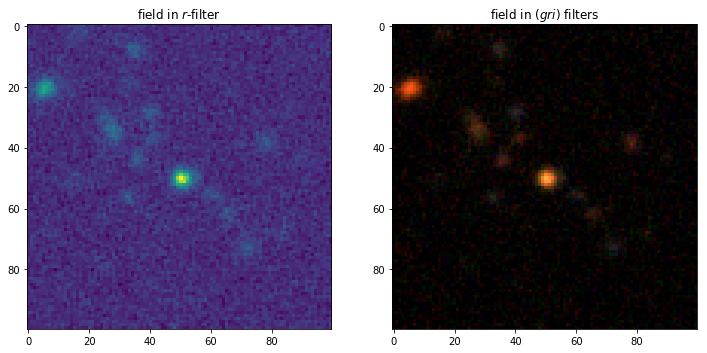

In [133]:
fig, axes = plt.subplots(1, 2, figsize = (12,8))
axes[0].imshow(img[0,:,:,2])

bands = [3,2,1]
axes[1].imshow(np.clip(img[0][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('field in $r$-filter')
axes[1].set_title('field in $(gri)$ filters')

In [154]:
np.save('../data/dc2_imgs/field/field_img.npy', img)

### Retrieve stamps for galaxies in the field

Need to go for all previous steps taking only the $(ra, dec)$ limits from the field.

In [135]:
# Match the corresponding area for the truth catalog
max_ra = ra+int(imsize/2)*0.00027
min_ra = ra-int(imsize/2)*0.00027
max_dec = dec+int(imsize/2)*0.00027
min_dec = dec-int(imsize/2)*0.00027
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

In [136]:
# Define a mag cut for truth catalog 
truth_mag_filters = ['mag_r < '+str(mag_cut)]

# Load wanted quantities from truth catalog (https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md)
quantities = ['galaxy_id', 'ra', 'dec', 
              'redshift', 'redshift_true',
              'mag_r_lsst',
              'ellipticity_1_true', 'ellipticity_2_true',
              'convergence',
              'shear_1', 'shear_2']


truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

In [137]:
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.
results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=0.1, # Linking length of 1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)

In [138]:
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))

In [141]:
print('There are '+str(len(truth_idx))+' galaxies found on the image. Extract stamps around these '+str(len(truth_idx))+' galaxies and the corresponding parameters.')

There are 27 galaxies found on the image. Extract stamps around these 27 galaxies and the corresponding parameters.


In [148]:
e1 = []
e2 = []
hsm_e1 = []
hsm_e2 = []
shear1=[]
shear2=[]
redshift=[]
idx = []
blend = []
redshift_true=[]
convergence=[]
snr = []

img_field = np.zeros((len(truth_idx),59,59,6))
psf_field = np.zeros((len(truth_idx),59,59,6))
filters = ['u','g','r','i','z','y']

In [149]:
for i in range (len(truth_idx)):
    first = id_ra_dec[object_idx[i]]
    ra, dec = first['ra'], first['dec']
    print(i)
    for k, filter_k in enumerate (filters):
        if k == 0:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_u, ra, dec, filter=filter_k, cutoutSideLength=59)
        else:
            cutout = cutout_img_dc2.cutout_coadd_ra_dec(butler_grizy, ra, dec, filter=filter_k, cutoutSideLength=59)

        radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
        xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

        img_field[i,:,:,k]= cutout.image.array
        if (cutout.getPsf().computeKernelImage(xy).array.size != 3481):
            print('not taken into account')
            break
        else:
            psf_field[i,:,:,k]= cutout.getPsf().computeKernelImage(xy).array

    idx.append(truth_data['galaxy_id'][truth_idx[i]])
    e1.append(truth_data['ellipticity_1_true'][truth_idx[i]])
    e2.append(truth_data['ellipticity_2_true'][truth_idx[i]])
    hsm_e1.append(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]])
    hsm_e2.append(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]])
    shear1.append(truth_data['shear_1'][truth_idx[i]])
    shear2.append(truth_data['shear_2'][truth_idx[i]])
    redshift.append(truth_data['redshift'][truth_idx[i]])
    blend.append(object_data['blendedness'][object_idx[i]])
    snr.append(object_data['snr_r_cModel'][object_idx[i]])
    redshift_true.append(truth_data['redshift_true'][truth_idx[i]])
    convergence.append(truth_data['convergence'][truth_idx[i]])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


### Now let's take a look a these galaxies:

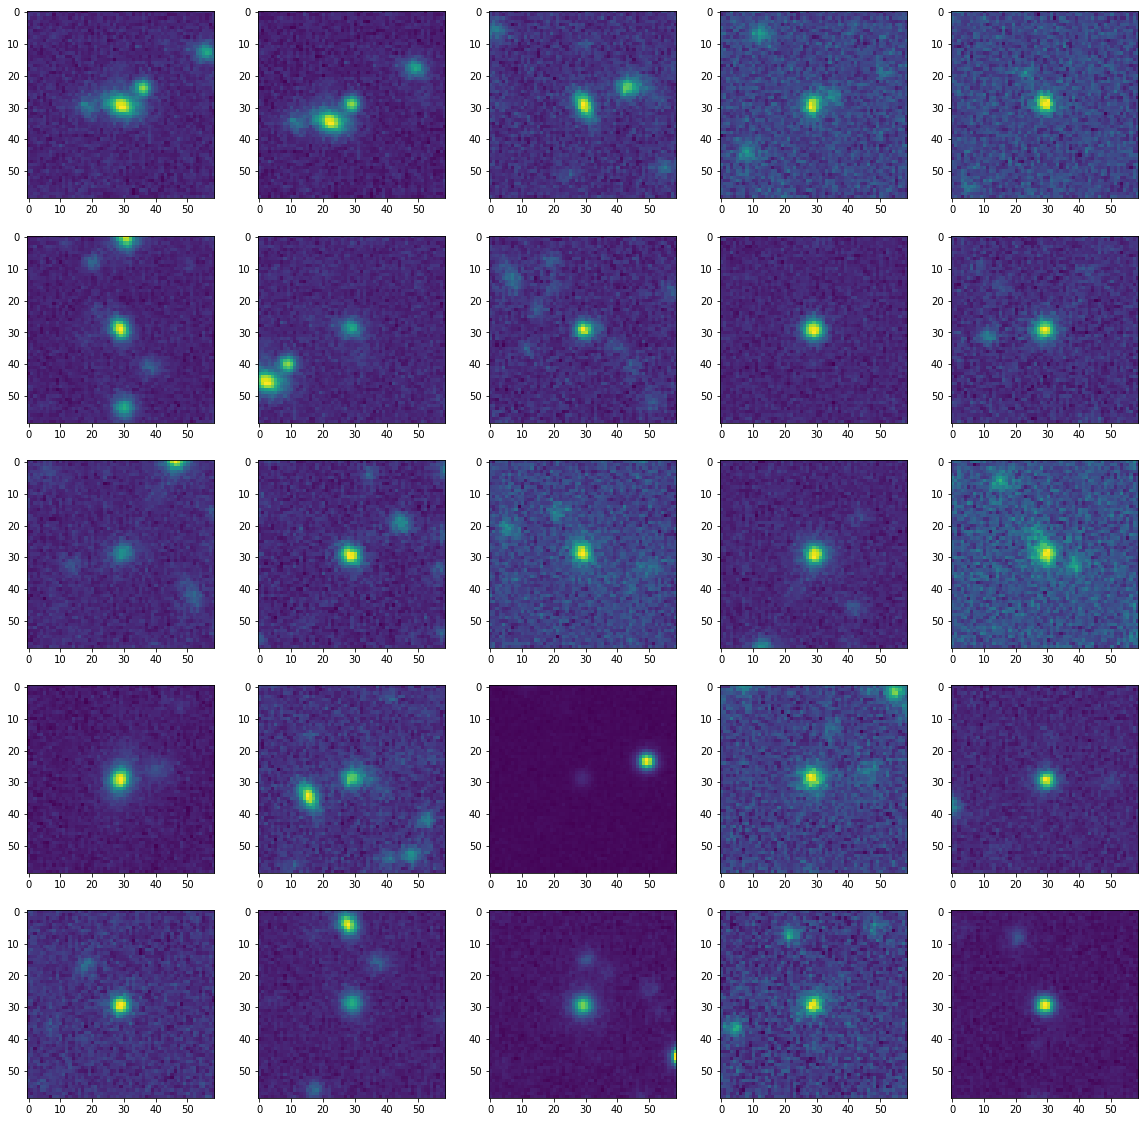

In [150]:
fig, axes = plt.subplots(5, 5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        axes[i,j].imshow(img_field[i*5+j,:,:,2])

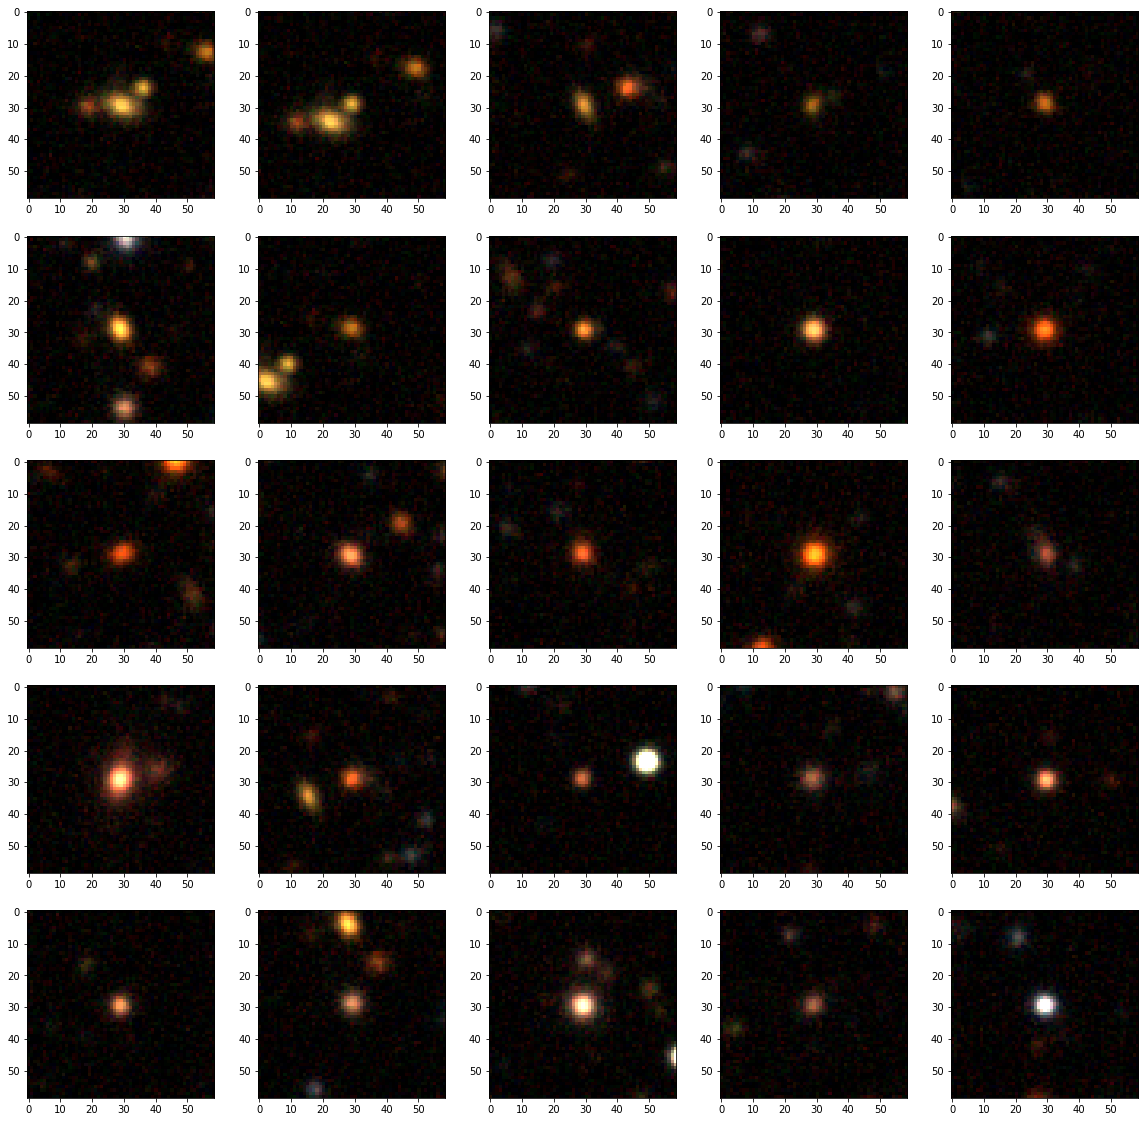

In [151]:
fig, axes = plt.subplots(5, 5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        axes[i,j].imshow(np.clip(img_field[i*5+j][:,:,bands], a_min=0.0, a_max=1.))

In [155]:
np.save('../data/dc2_imgs/field/galaxies_from_field.npy', img_field)